In [1]:
import pandas as pd 
import numpy as np

In [3]:
df=pd.read_csv("Natixis.csv",sep=";")

In [5]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df['Cours de Natixis'] = (
    df['Cours de Natixis']
    .astype(str)                       # transformer en string pour manipuler
    .str.replace("€", "", regex=False) # enlever symbole euro si présent
    .str.replace(" ", "", regex=False) # enlever les espaces
    .str.replace(",", ".", regex=False) # remplacer virgule par point
)

df['Cours de Natixis'] = pd.to_numeric(df['Cours de Natixis'], errors='coerce')

In [7]:
df['Rendement'] = (
    df['Cours de Natixis'].shift(-1) - df['Cours de Natixis']
) / df['Cours de Natixis']

In [9]:
df_2015 = df[(df['Date'] >= "2015-01-01") & (df['Date'] <= "2015-12-31")]
df_2016 = df[(df['Date'] >= "2016-01-01") & (df['Date'] <= "2016-12-31")]
df_2017 = df[(df['Date'] >= "2017-01-01") & (df['Date'] <= "2017-12-31")]
df_2018 = df[(df['Date'] >= "2018-01-01") & (df['Date'] <= "2018-12-31")]

In [11]:
volatility_2015=df_2015["Rendement"].std()
volatility_2016=df_2016["Rendement"].std()
volatility_2017=df_2017["Rendement"].std()
volatility_2018=df_2018["Rendement"].std()

In [13]:
annual_volatility2015=volatility_2015*np.sqrt(256)
annual_volatility2016=volatility_2016*np.sqrt(256)
annual_volatility2017=volatility_2017*np.sqrt(256)
annual_volatility2018=volatility_2018*np.sqrt(256)

In [15]:
print("📈 Volatilité annualisée (Natixis) :")
print(f"2015 : {annual_volatility2015:.2%}")
print(f"2016 : {annual_volatility2016:.2%}")
print(f"2017 : {annual_volatility2017:.2%}")
print(f"2018 : {annual_volatility2018:.2%}")

📈 Volatilité annualisée (Natixis) :
2015 : 32.33%
2016 : 43.29%
2017 : 25.54%
2018 : 25.19%


In [17]:
returns = df_2015["Rendement"].dropna()
mean_return_2015 = returns.mean()
negative_returns_2015 = returns[returns < mean_return_2015]
lower_semi_deviation_2015 = np.sqrt(((negative_returns_2015 - mean_return_2015) ** 2).sum()/len(df_2015))*np.sqrt(256)
print(f"📉 Lower Semi-Deviation : {lower_semi_deviation_2015:.4%}")

📉 Lower Semi-Deviation : 22.8623%


In [19]:
mean_return_2015 = returns.mean()
positive_returns_2015 = returns[returns > mean_return_2015]
upper_semi_deviation_2015 = np.sqrt(((positive_returns_2015 - mean_return_2015) ** 2).sum()/len(df_2015))*np.sqrt(256)
print(f"📉 Lower Semi-Deviation : {upper_semi_deviation_2015:.4%}")

📉 Lower Semi-Deviation : 22.7717%


In [21]:
df["Rendement log"]= np.log( df['Cours de Natixis'] / df['Cours de Natixis'].shift(-1))

In [23]:
alpha = 0.06
RW = np.zeros(len(df))
RW[0] = df.loc[0, "Rendement log"]
for t in range(1, len(df)):
    RW[t] = alpha * df.loc[t, "Rendement"] + (1 - alpha) * RW[t - 1]

df["RW"] = RW

In [25]:
mean_return_logs=df["Rendement log"].mean()
std_return_logs=df["Rendement log"].std()

In [27]:
# Estimate Brownian motion parameters
mu_hat = mean_return_logs + 0.5 * std_return_logs**2
sigma_hat = std_return_logs

print("Estimated parameters of the Brownian Motion (2015–2018):")
print(f"Drift (μ)    = {mu_hat:.6f} per day")
print(f"Volatility (σ) = {sigma_hat:.6f} per day")

# Optional: convert to annualized estimates (assuming 256 trading days)
mu_annual = mu_hat * 256
sigma_annual = sigma_hat * np.sqrt(256)

print("\nAnnualized parameters:")
print(f"Drift (μ_annual)    = {mu_annual:.6f}")
print(f"Volatility (σ_annual) = {sigma_annual:.6f}")

Estimated parameters of the Brownian Motion (2015–2018):
Drift (μ)    = 0.000513 per day
Volatility (σ) = 0.020415 per day

Annualized parameters:
Drift (μ_annual)    = 0.131223
Volatility (σ_annual) = 0.326638


In [29]:
import matplotlib.pyplot as plt

S_t = df.loc[df['Date'].idxmax(), "Cours de Natixis"] 
dt = 1 
N = 1000

np.random.seed(42)
Z = np.random.randn(N)
S_t1 = S_t * np.exp((mu_hat - 0.5 * sigma_hat**2) * dt + sigma_hat * np.sqrt(dt) * Z)

# --- Results ---
sim_returns = (S_t1 / S_t) - 1
mean_price = np.mean(S_t1)
VaR_95 = -np.percentile(sim_returns, 5)
VaR_99 = -np.percentile(sim_returns, 1)

print(f"Last observed price (S_t): {S_t:.2f}")
print(f"Mean simulated price (S_t+1): {mean_price:.2f}")
print(f"95% VaR (1-day horizon): {VaR_95:.4%}")
print(f"99% VaR (1-day horizon): {VaR_99:.4%}")


Last observed price (S_t): 4.12
Mean simulated price (S_t+1): 4.12
95% VaR (1-day horizon): 3.0377%
99% VaR (1-day horizon): 4.1328%


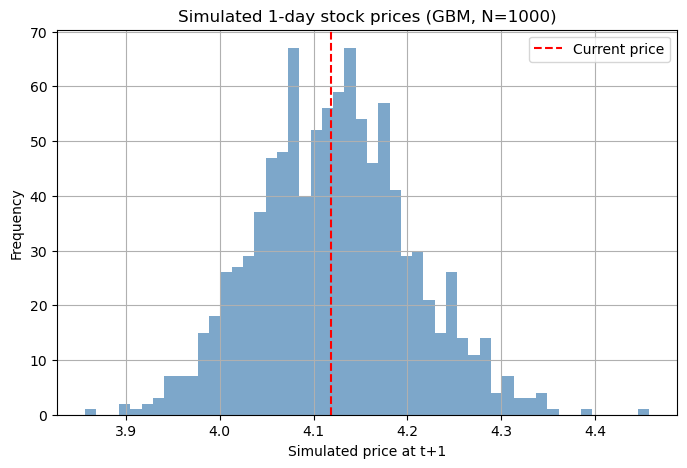

In [31]:
plt.figure(figsize=(8,5))
plt.hist(S_t1, bins=50, color='steelblue', alpha=0.7)
plt.axvline(S_t, color='red', linestyle='--', label='Current price')
plt.title("Simulated 1-day stock prices (GBM, N=1000)")
plt.xlabel("Simulated price at t+1")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
from scipy.stats import norm

S_t = df.loc[df['Date'] == '2018-12-31', 'Cours de Natixis'].values[0]  # prix du 31/12/2018
sigma_daily = std_return_logs  # volatilité journalière estimée
S_sim = S_t1  # les prix simulés du lendemain (tu les as déjà)
t = 1
T = 22
r = 0
q = 0

# --- Calcul Black-Scholes ---
tau_days = T - t
sqrt_tau = np.sqrt(tau_days)
sigma = sigma_daily

# Strike = prix du 31/12/2018 (fixe)
K = float(df.loc[df['Date'].idxmax(), "Cours de Natixis"])
S = np.asarray(S_sim)
eps = 1e-12
S = np.maximum(S, eps)
K = np.maximum(K, eps)

lnSK = np.log(S / K)
denom = sigma * sqrt_tau
d1 = (lnSK + 0.5 * sigma**2 * tau_days) / denom
d2 = d1 - denom

# r = 0, q = 0 donc pas d'actualisation
call_prices = S * norm.cdf(d1) - K * norm.cdf(d2)

# --- Résultats ---
mean_call = np.mean(call_prices)
median_call = np.median(call_prices)
quantiles = np.percentile(call_prices, [1, 5, 50, 95, 99])

print("----- Call Pricing Summary -----")
print(f"Strike (K) = {K:.2f}")
print(f"Mean call price: {mean_call:.4f}")
print(f"Median call price: {median_call:.4f}")
print(f"Quantiles (1%,5%,50%,95%,99%) = {quantiles}")

----- Call Pricing Summary -----
Strike (K) = 4.12
Mean call price: 0.1591
Median call price: 0.1554
Quantiles (1%,5%,50%,95%,99%) = [0.08043044 0.09692528 0.15543392 0.23927991 0.27770449]


In [41]:
# --- Calcul de la VaR ---
alpha_levels = [0.95, 0.99]
sqrt_tau = np.sqrt(tau_days)
d1_0 = (0.5 * sigma**2 * tau_days) / (sigma * sqrt_tau)
d2_0 = d1_0 - sigma * sqrt_tau
call_today = S_t * norm.cdf(d1_0) - K * norm.cdf(d2_0)
VaR_results = {}
for alpha in alpha_levels:
    q = np.percentile(call_prices, (1 - alpha) * 100)  # ex: 5e percentile pour alpha=0.95
    VaR = call_today - q
    VaR_results[alpha] = VaR

# --- Résultats ---
print("=== Value-at-Risk (empirical quantile) for the call ===")
print(f"Current call price (C0): {call_today:.6f}")
for alpha, var_value in VaR_results.items():
    print(f"VaR at {int(alpha*100)}% confidence: {var_value:.6f}")

=== Value-at-Risk (empirical quantile) for the call ===
Current call price (C0): 0.153674
VaR at 95% confidence: 0.056749
VaR at 99% confidence: 0.073244
